# Dynamische Programmierung
## Dirkete Verfahren, volldiskretisierung

In [176]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import casadi as cas
import optimierung as libop

## 1. Model

In [177]:
global nx, nu, nxu, N, t, Ta, S, M, Q, R, b_


t_end = 4
N = 100
t = np.linspace(0,t_end,N+1)

# Anzahl an Zuständen und Eingängen
nx = 4
nu = 1
nxu = nx+nu

dt = t_end/N

S = np.zeros((nx,nx))
S[2,2] = 5
#S = np.eye(nx)*5

M = np.eye(4)
Q = np.eye(4)
R = np.array([[0.1]])
b_ = [0,0,0,0]

In [178]:
# Parameter
global J,a,m,d,g

J = 0.0361  # kgm²
a = 0.42    # m
m = 0.3553  # kg
d = 0.005   # Nms
g = 9.81    # m/s²

# 2. Model und Kostenfunktion

In [179]:
# System dynamic
def System_dynamic(x,u):
    
    phidot= x[1]
    phiddot = (m*g*np.sin(x[1])+m*a*np.cos(x[0])*u-d*x[1])/(J+m*a**2) 
    v = x[3]
    vdt = u

    return cas.vertcat(phidot, phiddot, v, vdt)


# Cost function
def cost(x,u):
    # x = [x0 x1 x2 x3 ..], und u = [u0,u1,u2,u3,...]    
    
    cost_ = x[:,N-2].T@S@x[:,N-1]/2            # Endkostenterm 0.5*xSx
    for k in range(0,N-1):           
        cost_ += dt*(1+x[:,k].T@Q@x[:,k])/2    #  laufende Kosten  1 + 0.5*(xQx + uRu)       
        cost_ += dt*u[:,k].T@R@u[:,k]/2
    
    return cost_

# 3. Optimierung

In [182]:
# Opti

opti = cas.casadi.Opti()

# Minimiere x und u
x = opti.variable(nx,N+1) # State vector [Theta, Omega, s, v]
u = opti.variable(nu,N) # Control vector




# Dynamic Constraints
# with Forwardiff
for k in range(N):
    #xnew=  x[:,k] + System_dynamic(x[:,k],u[:,k])*dt                                      # Vorwärtsdiffernetation
    xnew = x[:,k] + (System_dynamic(x[:,k],u[:,k])+System_dynamic(x[:,k+1],u[:,k]))*dt/2     # Trapezregel
    #xnew =  libop.runge_kutta_k4(System_dynamic,x[:,k],u[:,k]),dt)                          # Runge Kutta rk4
    opti.subject_to(x[:,k+1] == xnew)

# Boundary Conditions
x0 = [np.pi,0.1,0,0] 
xN = [0,0,0,0]

opti.subject_to(x[:,0] == x0)
opti.subject_to(x[0,N] == 0)

# Path constraints
#opti.subject_to(opti.bounded(-0.7,cas.vec(x[2]),0.7))
opti.subject_to(x[2,:] <= 0.7)
opti.subject_to(x[2,:] >= -0.7)

opti.subject_to(u <=  10)
opti.subject_to(u >= -10)

# Cost-function
 
opti.minimize(cost(x,u))

# Solve
#opti.set_initial(u[:],-0.2) #; % Initial guess for mass
#opti.set_initial(x[:,0], x0 )
#opti.set_initial(x[:,-1], xN )

opti.solver('ipopt')
sol = opti.solve()


This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1605
Number of nonzeros in inequality constraint Jacobian.:      402
Number of nonzeros in Lagrangian Hessian.............:     1309

Total number of variables............................:      504
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      405
Total number of inequality constraints...............:      402
        inequality constraints with only lower bounds:      201
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      201

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.9800000e+00 3.14e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:159:
.../casadi/core/optistack_internal.cpp:997: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Infeasible_Problem_Detected'

# 4. Überprüfung

In [ ]:
# Simulate the dynamiks

def close_loop(sol):
    xhist = np.zeros((nx,N+1))    
    
    uhist = sol.value(u)
    xhist[:,0] = x0

    for k in range(0,N):                                              
        
        xhist[:,k+1] =  np.array([libop.runge_kutta_k4(System_dynamic, xhist[:,k], uhist[k],h=dt)]).flatten()
               
              
    return xhist,uhist


In [ ]:
xhist,uhist = close_loop(sol)

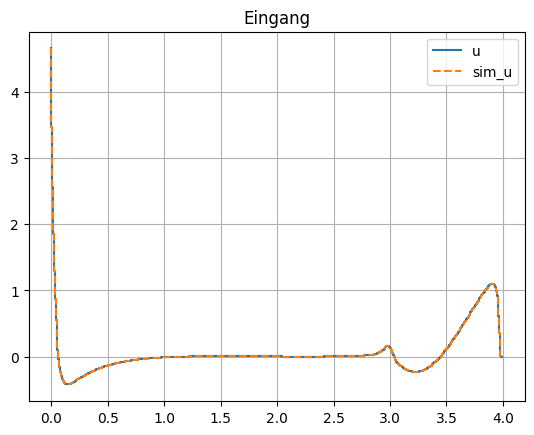

In [ ]:
plt.step(t[:-1],sol.value(u), label = 'u')
plt.step(t[:-1],uhist, label='sim_u', linestyle='--')
plt.title('Eingang')
plt.grid()
plt.legend()

(4, 501)
Start [3.14159265e+00 1.00000000e-01 0.00000000e+00 2.37644348e-29]
Ziel [ 0.         -3.12159114 -0.01047636  0.25276557]


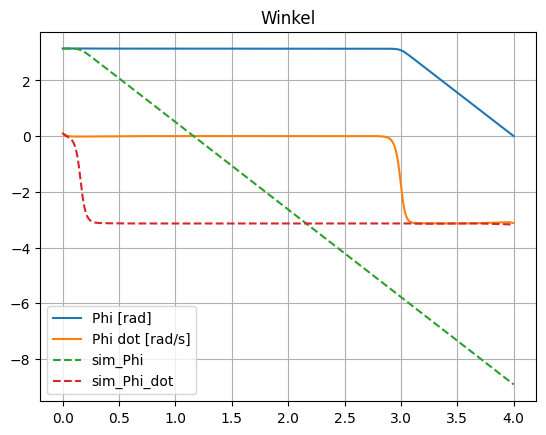

In [ ]:
print(np.shape(sol.value(x)))
plt.plot(t,sol.value(x[0,:]), label = 'Phi [rad]')
plt.plot(t,sol.value(x[1,:]), label = 'Phi dot [rad/s]')
plt.plot(t,xhist[0,:],   label='sim_Phi', linestyle='--')
plt.plot(t,xhist[1,:],   label='sim_Phi_dot', linestyle='--')
plt.title('Winkel')
plt.grid()
plt.legend()
print('Start',sol.value(x[:,0]))
print('Ziel',sol.value(x[:,-1]))

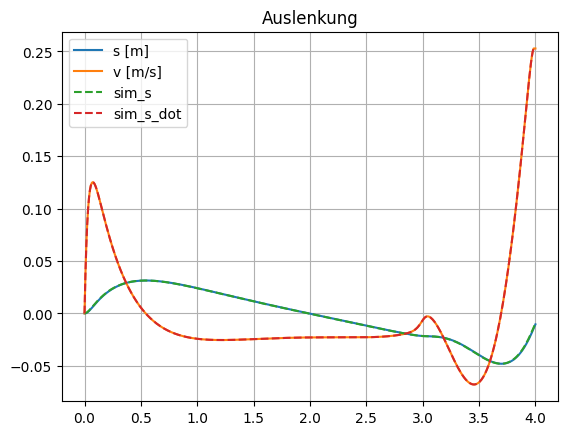

In [ ]:
plt.plot(t,sol.value(x[2,:]), label = 's [m]')
plt.plot(t,sol.value(x[3,:]), label = 'v [m/s]')
plt.plot(t,xhist[2,:],   label='sim_s', linestyle='--')
plt.plot(t,xhist[3,:],   label='sim_s_dot', linestyle='--')
plt.title('Auslenkung')
plt.grid()
plt.legend()